# Image segmentation in Tensorflow

## Importing Library

In [1]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-hlwegb4o
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-hlwegb4o
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a751758c2ea744412fb366e14c99901a983f6127_-py3-none-any.whl size=270903 sha256=29a6c9c5f6de39c16f13d1cf8bd2ed8a7a1ad42ebf5aa8a58ab15171c9578e02
  Stored in directory: /tmp/pip-ephem-wheel-cache-uvb8ss8m/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... - \ | done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
     |████████████████████████████████| 4.0 MB 806 kB/s 


In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.layers import Input, Conv2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import clear_output
import random, re, math
import pandas as pd 
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import zipfile

## Extracting the files

In [3]:

train_img_zip = '/kaggle/input/carvana-image-masking-challenge/train.zip'
train_mask_zip='/kaggle/input/carvana-image-masking-challenge/train_masks.zip'

train_img = zipfile.ZipFile(train_img_zip, 'r')
train_img.extractall('/kaggle/working')
train_img.close()

train_mask = zipfile.ZipFile(train_mask_zip, 'r')
train_mask.extractall('/kaggle/working')
train_mask.close()

In [4]:

train_dir = os.path.join('/kaggle/working/train')
train_mask_dir = os.path.join('/kaggle/working/train_masks')


## Let's take a look at some image examples and their correponding mask from the dataset.

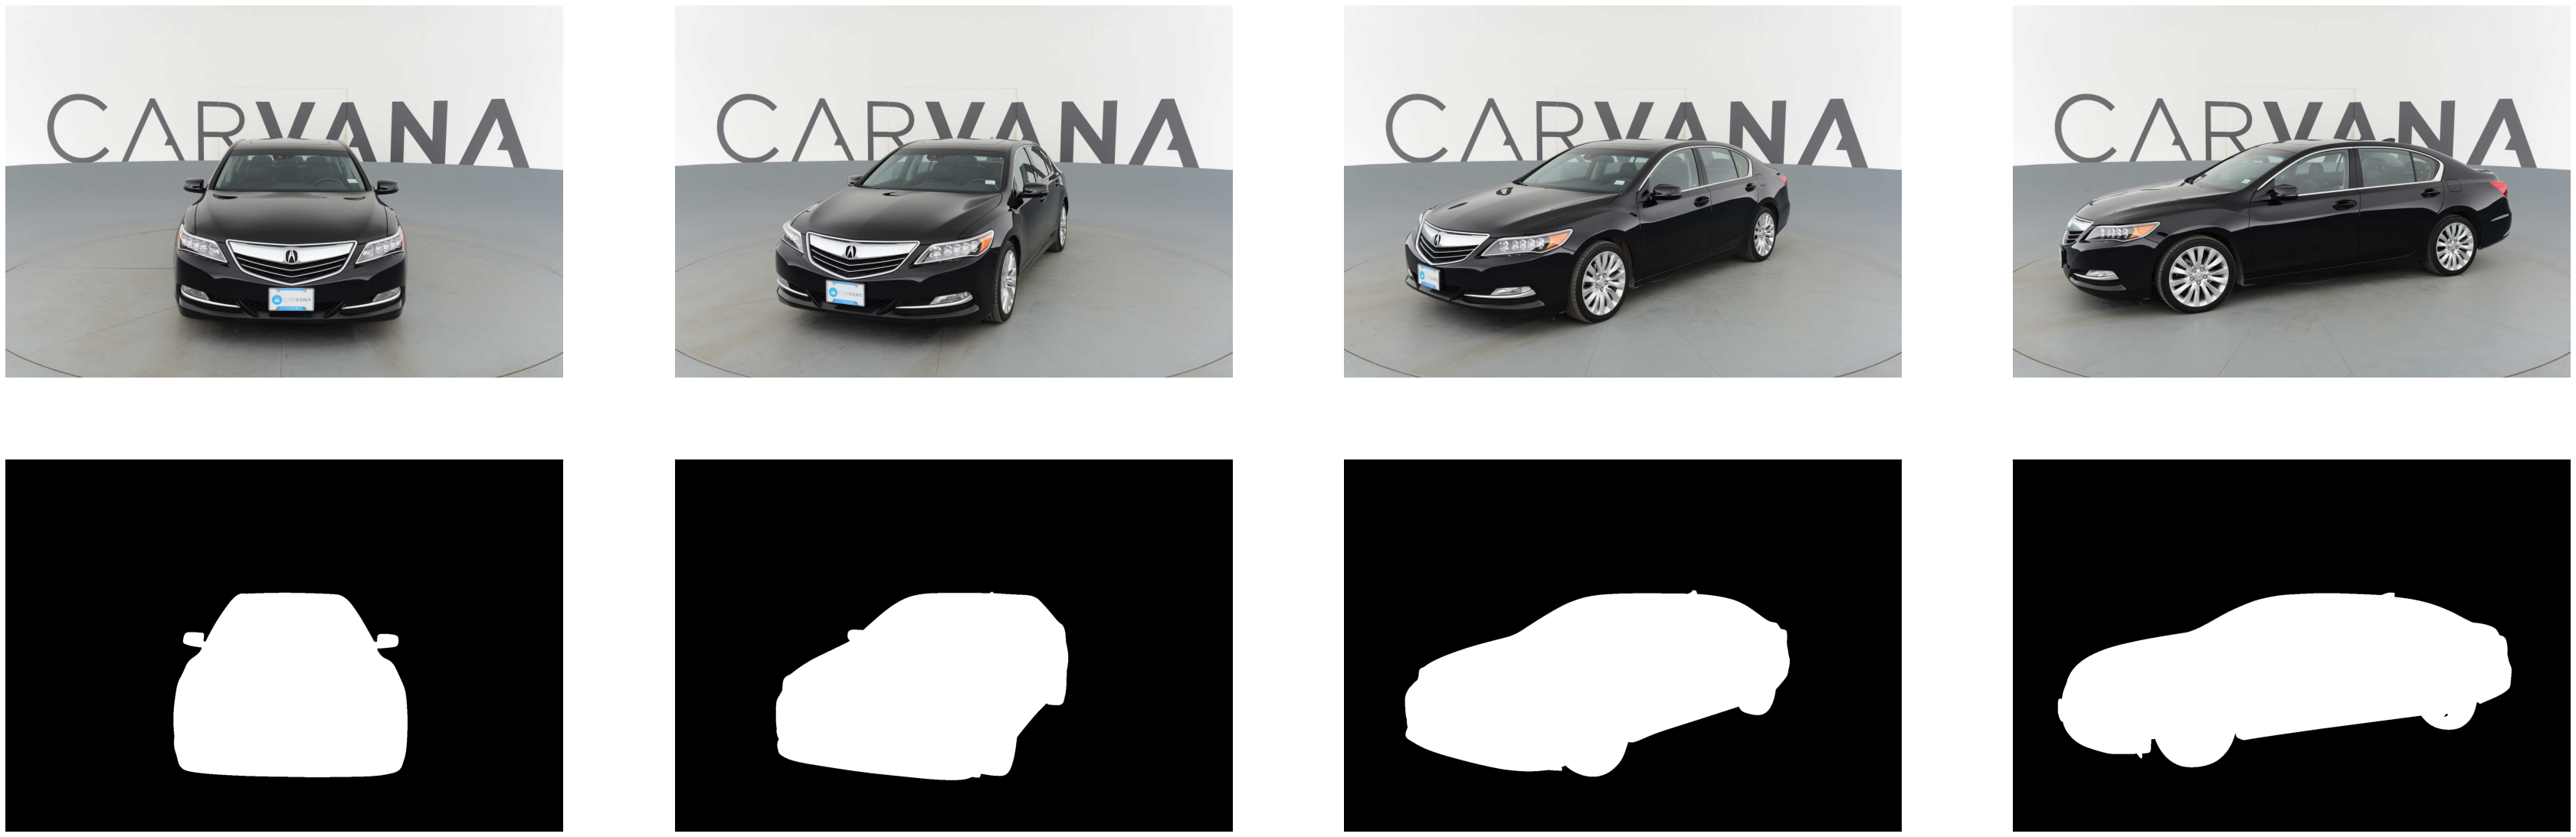

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.subplots(2, 5, figsize=(60, 20))
pic_index = 0


pic_index += 4
next_car_pix = [os.path.join(train_dir, fname) 
                for fname in sorted(os.listdir(train_dir))[pic_index-4:pic_index]]
next_mask_pix = [os.path.join(train_mask_dir, fname) 
                for fname in sorted(os.listdir(train_mask_dir))[pic_index-4:pic_index]]

for i, img_path in enumerate(next_car_pix+next_mask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(2, 4, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## the shape of one random image

In [6]:
img = mpimg.imread(train_dir+'/28d9a149cb02_12.jpg')

img.shape

(1280, 1918, 3)

## Making a dataframe to use in tensorflow dataset

#### We should make the image_path and mask_path have the same id:

In [7]:
def creat_dataframe(img_path,mask_path):

    car_ids = []
    car_paths = []
    mask_ids=[]
    mask_paths=[]
    for p in (img_path,mask_path):
        for dirname, _, filenames in os.walk(p):
            for filename in filenames:
                path = os.path.join(dirname, filename)  
                if p==img_path:
                    car_paths.append(path)
                    car_id = filename.split(".")[0]
                    car_ids.append(car_id)
                    df=pd.DataFrame(data = {"id": car_ids, "img_path": car_paths}).set_index('id')
                else:
                    mask_paths.append(path)
                    mask_id = filename.split(".")[0]
                    mask_id = mask_id.split("_mask")[0]
                    mask_ids.append(mask_id)
                    df_mask=pd.DataFrame(data = {"id": mask_ids, "mask_path": mask_paths}).set_index('id')
                    
    df["mask_path"] = df_mask["mask_path"]
         
    return df

In [8]:
df=creat_dataframe('/kaggle/working/train','/kaggle/working/train_masks')
df.head()

,img_path,mask_path
id,,
843763f47895_07,/kaggle/working/train/843763f47895_07.jpg,/kaggle/working/train_masks/843763f47895_07_ma...
78bfb9c780db_12,/kaggle/working/train/78bfb9c780db_12.jpg,/kaggle/working/train_masks/78bfb9c780db_12_ma...
b1a27da4f01c_12,/kaggle/working/train/b1a27da4f01c_12.jpg,/kaggle/working/train_masks/b1a27da4f01c_12_ma...
40851e617b93_02,/kaggle/working/train/40851e617b93_02.jpg,/kaggle/working/train_masks/40851e617b93_02_ma...
5df60cf7cab2_11,/kaggle/working/train/5df60cf7cab2_11.jpg,/kaggle/working/train_masks/5df60cf7cab2_11_ma...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5088 entries, 843763f47895_07 to 6bff9e10288e_11
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   5088 non-null   object
 1   mask_path  5088 non-null   object
dtypes: object(2)
memory usage: 119.2+ KB


## Configuration

In [10]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
IMAGE_SIZE = [256, 256]
EPOCHS = 40
SEED = 777
BATCH_SIZE = 16 

## Dataset  functions

In [11]:
def flip(image,mask):
    
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    
    return image,mask

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
        
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))
  
    
def transform(image,mask):
    # is borrowed from https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 
    
    rot = 10. * tf.random.normal([1],dtype='float32')
    shr = 2. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 10. * tf.random.normal([1],dtype='float32') 
    w_shift = 10. * tf.random.normal([1],dtype='float32') 
  
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
    m = tf.gather_nd(mask,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),tf.reshape(m,[DIM,DIM,1])




def read_image_and_mask(image_path, mask_path=None,resize=IMAGE_SIZE):
    
    image=tf.io.read_file(image_path)
    image=tf.image.decode_jpeg(image, channels=3)
    image=tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, dtype=tf.float32)/255.
    if not mask_path is None:
        mask=tf.io.read_file(mask_path)
        mask=tf.image.decode_jpeg(mask, channels=3)
        mask=mask[:,:,:1]
        mask=tf.image.resize(mask, IMAGE_SIZE)
        mask = tf.cast(mask, dtype=tf.float32)/255.
        return image, mask
    return image




def get_training_dataset(df):
    
    training_dataset = tf.data.Dataset.from_tensor_slices((df["img_path"].values, df["mask_path"].values))
    training_dataset = training_dataset.map(read_image_and_mask,num_parallel_calls=AUTO)
    training_dataset = training_dataset.map(flip,num_parallel_calls=AUTO)
    training_dataset = training_dataset.map(transform,num_parallel_calls=AUTO)
    training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
    training_dataset = training_dataset.batch(BATCH_SIZE)
    training_dataset = training_dataset.repeat()
    training_dataset = training_dataset.prefetch(AUTO)

    return training_dataset


def get_validation_dataset(df):
  
  validation_dataset = tf.data.Dataset.from_tensor_slices((df["img_path"].values, df["mask_path"].values))
  validation_dataset = validation_dataset.map(read_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  

  return validation_dataset


def get_test_dataset(images):
  
  test_dataset = tf.data.Dataset.from_tensor_slices((images))
  test_dataset = test_dataset.map(read_image_and_mask)
  test_dataset = test_dataset.batch(10, drop_remainder=True)

  return test_dataset

In [12]:
tr_df, val_df = train_test_split(creat_dataframe('/kaggle/working/train','/kaggle/working/train_masks'), random_state=SEED, test_size=.25)
tr_dataset = get_training_dataset(tr_df)
val_dataset = get_validation_dataset(val_df)

## Display Example Augmentation¶with mask


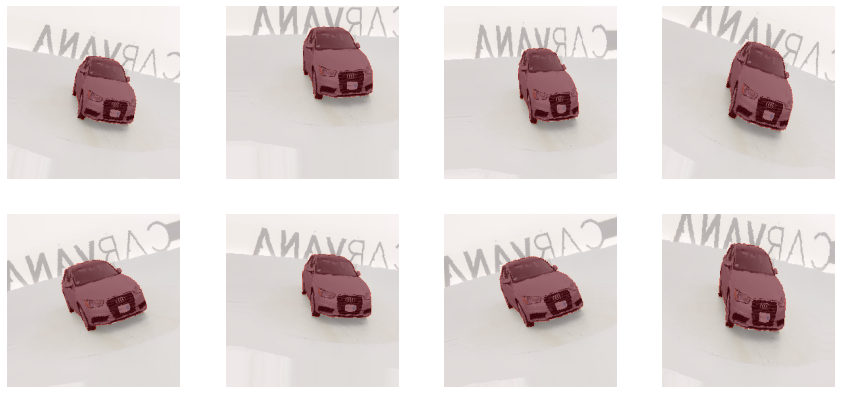

In [13]:
row = 2; col = 4;
all_elements = tr_dataset.unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,mask) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
        plt.imshow(mask[j,:,:,0],alpha=.5,cmap='Reds')
    plt.show()
    break

## Visualization function 

In [14]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [15]:
def batch_predict(image,model):
    preds=model.predict(image)  
    threshold = 0.5
    preds[preds > threshold] = 1.0
    preds[preds <= threshold] = 0.0 
    return preds

def vis_compare(dataset=val_dataset,num_case=1):
       
    for sample in dataset.take(1):
        image, label = sample[0].numpy(), sample[1].numpy()
    preds=batch_predict(image,model)
    if num_case>1:
        cases=[j for j in np.random.choice(image.shape[0],size=num_case,replace=False)]    
        for i in cases:
            truth=(image[i],label[i])
            pred=(image[i],preds[i])
            print(f"case_number_{i}")
            display([image,label,preds])
            print('\n')
            print(464*'*')
            print('\n')
    else:
        truth=(image[0],label[0])
        pred=(image[0],preds[0])
        display([image[0],label[0],preds[0]])
            
    
    
    plt.show() 

## useful callback class

#### Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 


In [16]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    vis_compare()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


In [17]:
class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=3):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
            


## Loss function

In [18]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

## Define the model


The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the Pix2pix tutorial.

In [19]:
OUTPUT_CHANNELS = 1
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)



layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]


base_model_outputs = [base_model.get_layer(name).output for name in layer_names]


down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  

    x = last(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

    return model





model = unet_model(1)








9412608/9406464 [==============================] - 0s 0us/step


## Train the model

In [20]:
steps_per_epoch = len(tr_df)//BATCH_SIZE


history = model.fit(tr_dataset,
                          steps_per_epoch=steps_per_epoch, validation_data=val_dataset, epochs=40,
                          callbacks=[EarlyStoppingAtMinLoss()]) #,DisplayCallback()

Epoch 1/40
238/238 [==============================] - 156s 575ms/step - loss: 0.2066 - dice_coef: 0.7934 - binary_accuracy: 0.8869 - val_loss: 0.1264 - val_dice_coef: 0.8736 - val_binary_accuracy: 0.9721
Epoch 2/40
238/238 [==============================] - 136s 571ms/step - loss: 0.0237 - dice_coef: 0.9763 - binary_accuracy: 0.9911 - val_loss: 0.0239 - val_dice_coef: 0.9761 - val_binary_accuracy: 0.9915
Epoch 3/40
238/238 [==============================] - 136s 571ms/step - loss: 0.0193 - dice_coef: 0.9807 - binary_accuracy: 0.9922 - val_loss: 0.0174 - val_dice_coef: 0.9826 - val_binary_accuracy: 0.9929
Epoch 4/40
238/238 [==============================] - 138s 580ms/step - loss: 0.0172 - dice_coef: 0.9828 - binary_accuracy: 0.9929 - val_loss: 0.0156 - val_dice_coef: 0.9844 - val_binary_accuracy: 0.9934
Epoch 5/40
238/238 [==============================] - 139s 588ms/step - loss: 0.0162 - dice_coef: 0.9838 - binary_accuracy: 0.9932 - val_loss: 0.0146 - val_dice_coef: 0.9854 - val_bina

## Evaluation

In [21]:
model.evaluate(val_dataset)

80/80 [==============================] - 63s 787ms/step - loss: 0.0107 - dice_coef: 0.9893 - binary_accuracy: 0.9952


[0.010702479630708694, 0.9892920255661011, 0.9952482581138611]

In [22]:
def vis_compare(dataset=val_dataset,num_case=1):
       
    for sample in dataset.take(1):
        image, label = sample[0].numpy(), sample[1].numpy()
    preds=model.predict(image)
    if num_case>1:
        cases=[j for j in np.random.choice(image.shape[0],size=num_case,replace=False)]    
        for i in cases:
            truth=(image[i],label[i])
            pred=(image[i],preds[i])
            print(f"case_number_{i}")
            display([image[i],label[i],preds[i]])
            print('\n')
            print(464*'*')
            print('\n')
    else:
        truth=(image[0],label[0])
        pred=(image[0],preds[0])
        display([image[0],label[0],preds[0]])
            
    
    
    plt.show()

case_number_0


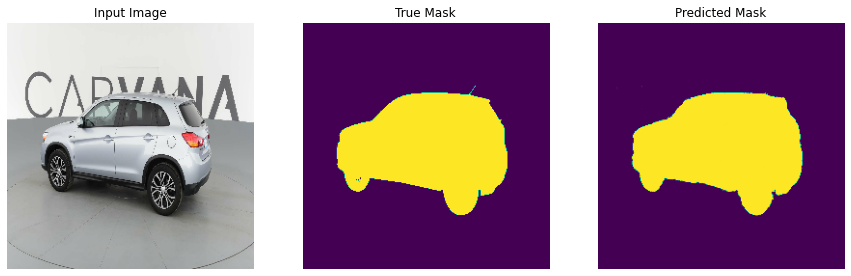



********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


case_number_14


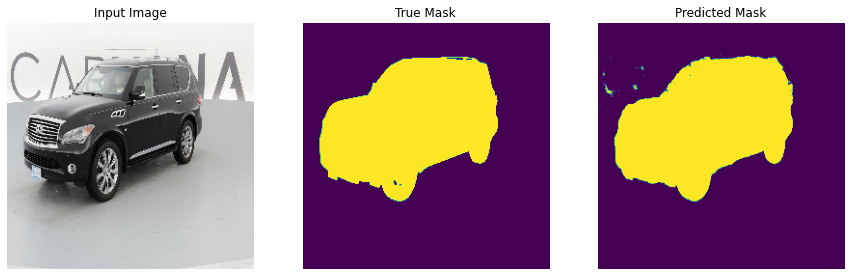



********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


case_number_6


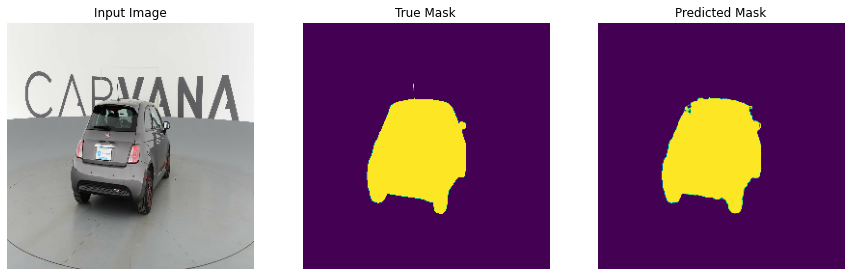



********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


case_number_15


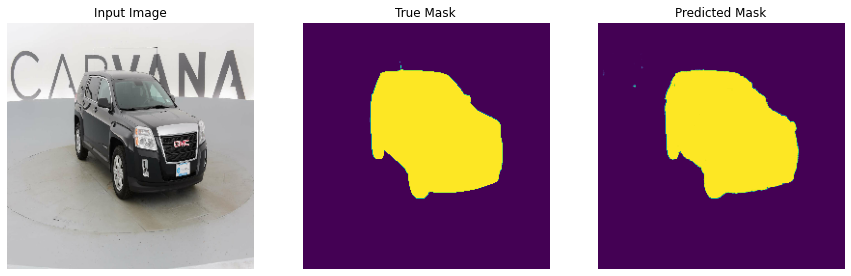



********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


case_number_13


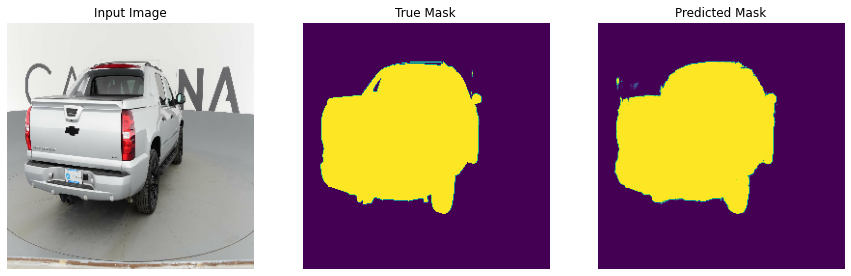



********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


case_number_4


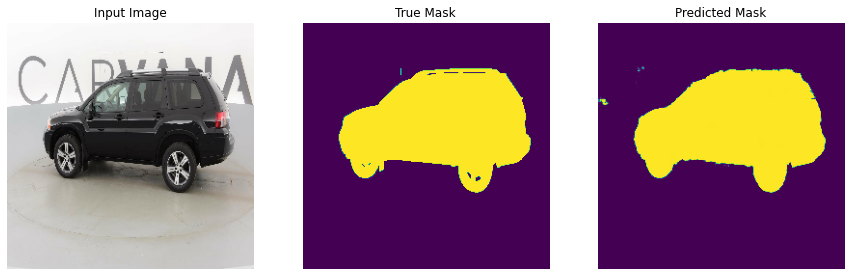



********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


case_number_12


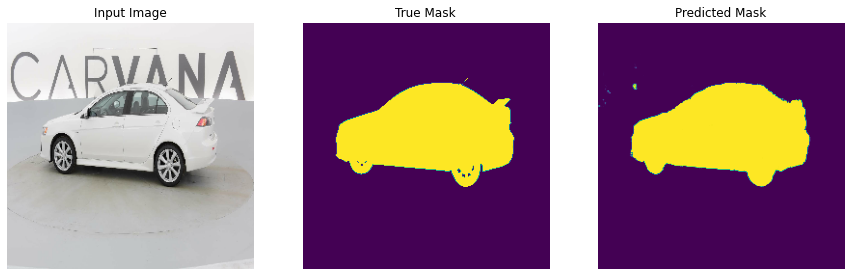



********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


case_number_8


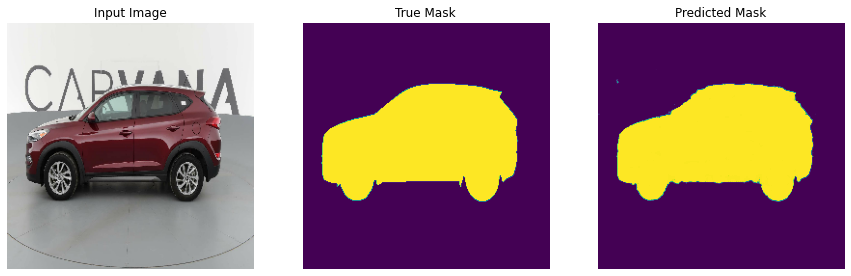



********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


case_number_9


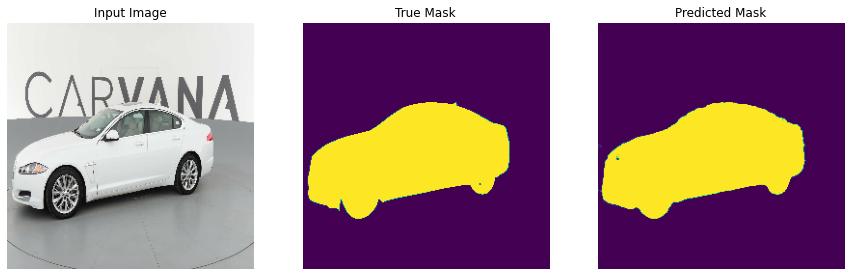



********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


case_number_1


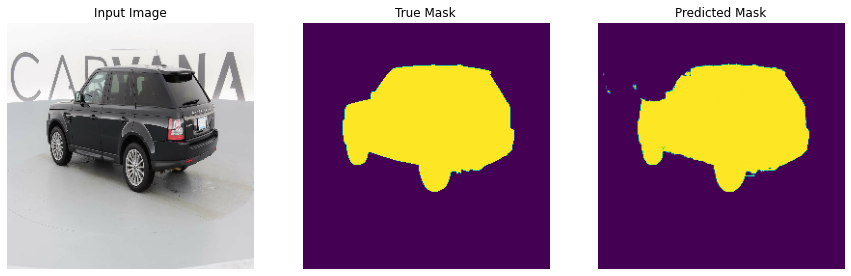



********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************




In [23]:
vis_compare(dataset=val_dataset,num_case=10)